In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm
import pandas as pd
import math
from scipy import stats
import mpl_scatter_density
import os

Load IFT Data

In [9]:
tree = IFT['spfit']
ift = tree.arrays(['sp_track_x',
                   'sp_track_y',
                   'sp_track_z',
                   'sp_track_x_err',
                   'sp_track_y_err',
                   'sp_track_z_err',
                   'sp_track_x_predicted',
                   'sp_track_y_predicted',
                   'sp_track_z_predicted',
                   'sp_track_x_residual',
                   'sp_track_y_residual',
                   'sp_track_z_residual',
                   'track_p1',
                   'track_p3'], library='ak')

In [11]:
x = np.array(IFT["spfit"]["sp_track_x"])
y = np.array(IFT["spfit"]["sp_track_y"])
z = np.array(IFT["spfit"]["sp_track_z"])
x_err = np.array(IFT["spfit"]["sp_track_x_err"])
y_err = np.array(IFT['spfit']['sp_track_y_err'])
p1 = np.array(IFT["spfit"]["track_p1"])  # tx
p3 = np.array(IFT["spfit"]["track_p3"])  # ty

def define_data(f):
    var = []
    f = f[len(f[:])!=0]
    
    for i in range(len(f[0])):
        if len(f[:,i][0]) == 3:
            var.append(f[:,i][0][0])
    return var

x_FIRST = define_data(x)
y_FIRST = define_data(y)
z_FIRST = define_data(z)
x_err_FIRST = define_data(x_err)
y_err_FIRST = define_data(y_err)
tx_FIRST = define_data(p1)
ty_FIRST = define_data(p3)


dict = {"x":x_FIRST, "y":y_FIRST, "z":z_FIRST, 'x error':x_err_FIRST, 'y error':y_err_FIRST, "tx":tx_FIRST, "ty":ty_FIRST}
mini_IFT = pd.DataFrame(dict)

Load Emulsion Data

In [12]:
# pre-process using PANDAS
area1_1 = pd.read_csv("Emulsion Data/chk_trks_area1-1_20220203.txt", sep='\s+', header=None)
area1_2 = pd.read_csv("Emulsion Data/chk_trks_area1-2_20220203.txt", sep='\s+', header=None)
area1_3 = pd.read_csv("Emulsion Data/chk_trks_area1-3_20220203.txt", sep='\s+', header=None)
area1_4 = pd.read_csv("Emulsion Data/chk_trks_area1-4_20220203.txt", sep='\s+', header=None)

combine = area1_1.append(area1_2, ignore_index=True)
combine = combine.append(area1_3, ignore_index=True)

emulsion = combine.append(area1_4, ignore_index=True)
emulsion.columns = ["t->ID", "plate_first", "plate_last", "x_last", "y_last", "z_last", 
                    "tx_last", "ty_last", "tx_pos", "ty_pos", "t->N()", "t->Npl()"]
emulsion_20 = emulsion[emulsion["plate_last"] == 20]

In [13]:
DistEmuIft = 65500

def Emu2Ift_Coor(x, y, tx, ty, mm=False, um=False, rotate=False):
    # Projection
    x_new = DistEmuIft * tx + x
    y_new = DistEmuIft * ty + y
    
    # Transition
    x_ift_pred = x_new - 70000
    y_ift_pred = y_new - 60000
    
    if um:
        return x_ift_pred, y_ift_pred
    elif mm:
        return x_ift_pred/1e3, y_ift_pred/1e3
    if rotate:
        x_ift_pred = x_new - 60000
        y_ift_pred = y_new - 70000
        
    return y_ift_pred, x_ift_pred


In [14]:
x_ift_pred, y_ift_pred = Emu2Ift_Coor(ak.Array(emulsion_20['x_last']), ak.Array(emulsion_20['y_last']), ak.Array(emulsion_20['tx_last']), ak.Array(emulsion_20['ty_last']), mm=True)
#DistEmuIft = 60000
#x_test, y_test = Emu2Ift_Coor(ak.Array(emulsion_20['x_last']), ak.Array(emulsion_20['y_last']), ak.Array(emulsion_20['tx_last']), ak.Array(emulsion_20['ty_last']), mm=True)

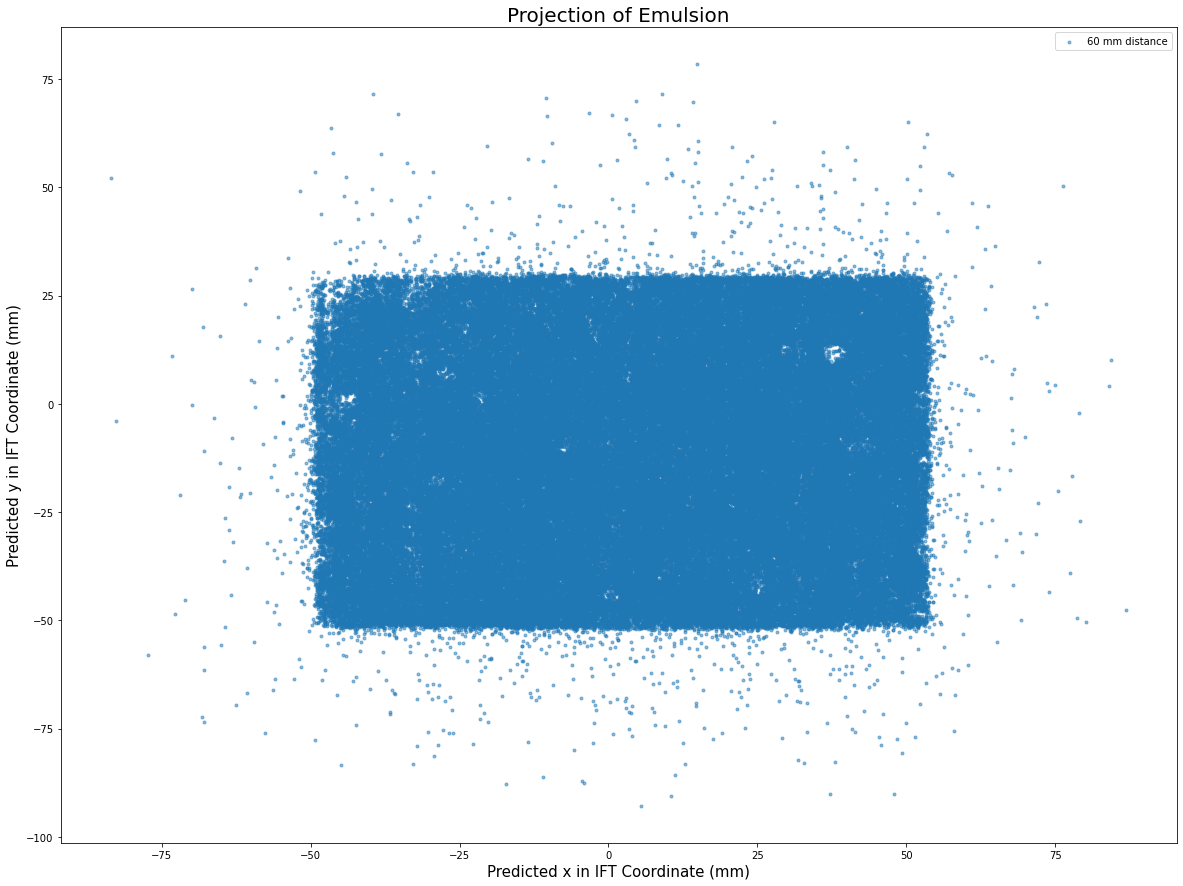

In [15]:
plt.figure(figsize=(20, 15))
plt.scatter(x_ift_pred, y_ift_pred, marker='.', alpha=0.5, label='60 mm distance')
#plt.scatter(x_test, y_test, marker='.', alpha=0.5, label='60 mm distance')
plt.xlabel('Predicted x in IFT Coordinate (mm)', fontsize=15)
plt.ylabel('Predicted y in IFT Coordinate (mm)', fontsize=15)
plt.title('Projection of Emulsion', fontsize=20)
plt.legend()
plt.show()

In [16]:
xmin = 59000
xmax = 61000
ymin = 59000
ymax = 61000

emulsion_pheri_2x2 = emulsion_20.loc[(emulsion_20["x_last"] >= xmin)]
emulsion_pheri_2x2 = emulsion_pheri_2x2.loc[(emulsion_pheri_2x2["x_last"] < xmax)]
emulsion_pheri_2x2 = emulsion_pheri_2x2.loc[(emulsion_pheri_2x2["y_last"] >= ymin)]
emulsion_pheri_2x2 = emulsion_pheri_2x2.loc[(emulsion_pheri_2x2["y_last"] < ymax)]

In [22]:
fig = plt.figure(figsize=(10,8))

plt.scatter(emulsion_pheri_2x2['x_last'], emulsion_pheri_2x2['y_last'], label="emulsion")
#plt.scatter(ift_small.iloc[:,0],ift_small.iloc[:,1],marker="o",s=150)
#plt.scatter(ift_small.iloc[:,0],ift_small.iloc[:,1])
#plt.title("x, y dist. (TEST)", size=20)
#plt.scatter(IFT_pheri.iloc[:,0],IFT_pheri.iloc[:,1],label="IFT")
plt.title("emulsion on top of IFT abs(tx), abs(ty) > 0.2 mrad", size=20)
plt.legend(fontsize=20)
plt.xlabel("x",size=20)
plt.ylabel("y",size=20)

Text(0, 0.5, 'y')

TX TY dist

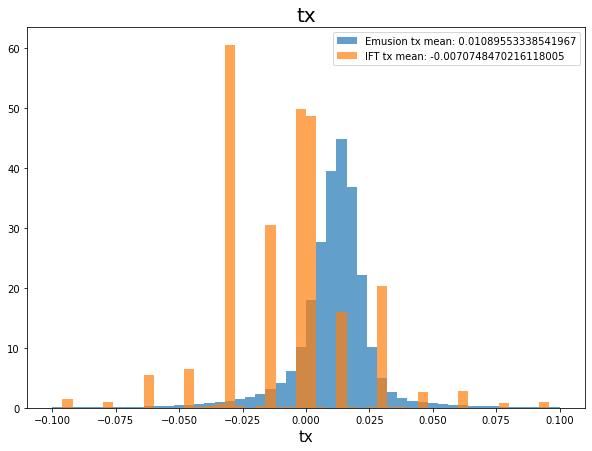

In [17]:
# tx
plt.figure(figsize=(10, 7))
emu_mean, ift_mean = np.mean(emulsion_20['tx_last']), np.mean(mini_IFT['tx'])
plt.hist(emulsion_20['tx_last'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion tx mean: {emu_mean}')
plt.hist(mini_IFT['tx'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'IFT tx mean: {ift_mean}')
plt.xlabel('tx', fontsize=15)
plt.title('tx', fontsize=20)
plt.legend()
plt.show()

# ty
plt.figure(figsize=(10, 7))
emu_mean, ift_mean = np.mean(emulsion_20['ty_last']), np.mean(mini_IFT['ty'])
plt.hist(emulsion_20['ty_last'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion ty mean: {emu_mean}')
plt.hist(mini_IFT['ty'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'IFT ty mean: {ift_mean}')
plt.xlabel('ty', fontsize=15)
plt.title('ty', fontsize=20)
plt.legend()
plt.show()

In [20]:
def AngleCorr(tx, ty):
    # tx = Delta_x/Delta_z, ty = Delta_y/Delta_z
    theta = np.arctan(np.sqrt(tx**2 + ty**2))
    phi = np.ones(len(tx))
    for i in range(len(tx)):
        if tx[i] > 0:
            phi[i] = np.arctan(ty[i]/tx[i])
        elif tx[i] < 0 and ty[i] >= 0:
            phi[i] = np.arctan(ty[i]/tx[i]) + np.pi
        elif tx[i] < 0 and ty[i] < 0:
            phi[i] = np.arctan(ty[i]/tx[i]) - np.pi
        elif tx[i] == 0 and ty[i] > 0: 
            phi[i] = np.pi/2
        elif tx[i] == 0 and ty[i] < 0:
            phi[i] = -np.pi/2
        elif tx[i] == 0 and ty[i] == 0:
            print(f'At Event {i}, there occurs both tx & ty values are zero (tx:{tx[i]}, ty:{ty[i]})')
            phi[i] = np.nan
        else:
            print('occur error')
    return theta, phi
theta_emu, phi_emu = AngleCorr(np.array(emulsion_20['tx_last']), np.array(emulsion_20['ty_last']))
theta_ift, phi_ift = AngleCorr(mini_IFT['tx'], mini_IFT['ty'])

At Event 57702, there occurs both tx & ty values are zero (tx:0.0, ty:0.0)
At Event 111508, there occurs both tx & ty values are zero (tx:0.0, ty:0.0)
At Event 114495, there occurs both tx & ty values are zero (tx:0.0, ty:-0.0)


In [44]:
#Delta_phi = np.nanmean(phi_emu) - np.mean(phi_ift)
Delta_phi = 0.55

In [45]:
ty_test = np.sin(phi_emu + Delta_phi) * np.sin(theta_emu)
tx_test = np.cos(phi_emu + Delta_phi) * np.sin(theta_emu)

#tx
plt.figure(figsize=(10, 7))
emu_mean, ift_mean = np.mean(emulsion_20['tx_last']), np.mean(mini_IFT['tx'])
#plt.hist(emulsion_20['tx_last'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion tx mean: {emu_mean}')

plt.hist(tx_test, bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion tx1 mean: {np.nanmean(tx_test)}')
plt.hist(mini_IFT['tx'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'IFT tx mean: {ift_mean}')
plt.xlabel('tx', fontsize=15)
plt.title('tx', fontsize=20)
plt.legend()
plt.show()

# ty
plt.figure(figsize=(10, 7))

emu_mean, ift_mean = np.mean(emulsion_20['ty_last']), np.mean(mini_IFT['ty'])
#plt.hist(emulsion_20['ty_last'], bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'Emusion ty mean: {emu_mean}')
emu_mean, ift_mean = np.nanmean(ty_test), np.mean(mini_IFT['ty'])
plt.hist(ty_test, bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'Emusion ty1 mean: {emu_mean}')
plt.hist(mini_IFT['ty'], bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'IFT ty mean: {ift_mean}')
plt.xlabel('ty', fontsize=15)
plt.title('ty', fontsize=20)
plt.legend()
plt.show()

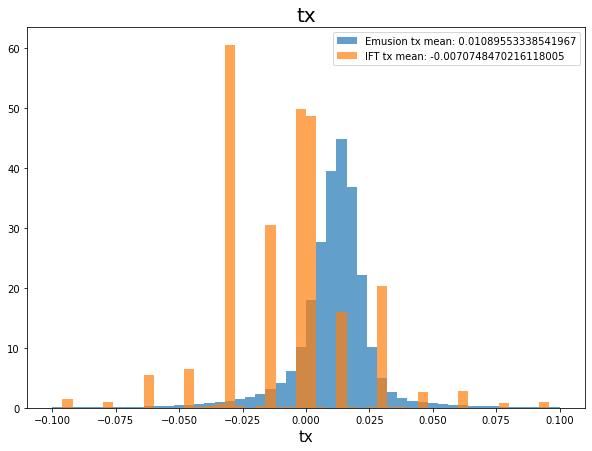

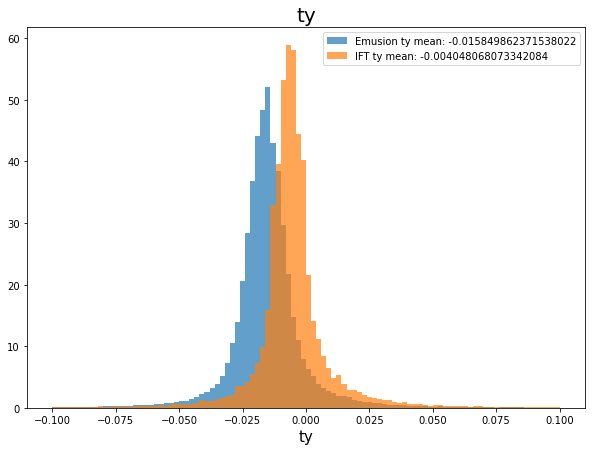

In [46]:
ty_test = np.sin(phi_emu + Delta_phi) * np.sin(theta_emu)
tx_test = np.cos(phi_emu + Delta_phi) * np.sin(theta_emu)

#tx
plt.figure(figsize=(10, 7))
emu_mean, ift_mean = np.mean(emulsion_20['tx_last']), np.mean(mini_IFT['tx'])
plt.hist(emulsion_20['tx_last'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion tx mean: {emu_mean}')

#plt.hist(tx_test, bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'Emusion tx1 mean: {np.nanmean(tx_test)}')
plt.hist(mini_IFT['tx'], bins=np.linspace(-0.1, 0.1, 51), alpha=0.7, density=True, label=f'IFT tx mean: {ift_mean}')
plt.xlabel('tx', fontsize=15)
plt.title('tx', fontsize=20)
plt.legend()
plt.show()

# ty
plt.figure(figsize=(10, 7))

emu_mean, ift_mean = np.mean(emulsion_20['ty_last']), np.mean(mini_IFT['ty'])
plt.hist(emulsion_20['ty_last'], bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'Emusion ty mean: {emu_mean}')
emu_mean, ift_mean = np.nanmean(ty_test), np.mean(mini_IFT['ty'])
#plt.hist(ty_test, bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'Emusion ty1 mean: {emu_mean}')
plt.hist(mini_IFT['ty'], bins=np.linspace(-0.1, 0.1, 101), alpha=0.7, density=True, label=f'IFT ty mean: {ift_mean}')
plt.xlabel('ty', fontsize=15)
plt.title('ty', fontsize=20)
plt.legend()
plt.show()